In [154]:
import sqlite3
import csv

conn = sqlite3.connect('airbnb.db')
c = conn.cursor()

In [155]:
def create_database(conn):
    """
    Using the database connection conn, create tables appropriate for 
    storing and using IMDB data.  Drops any pre-exsiting tables that would be re-defined by this procedure.
    """
    c = conn.cursor()
    c.execute('''DROP TABLE IF EXISTS 'listings' ''')
    c.execute('''DROP TABLE IF EXISTS 'neighborhoods' ''')
    c.execute('''DROP TABLE IF EXISTS 'calendar' ''')
    c.execute('''DROP TABLE IF EXISTS 'fact_table' ''')
    c.execute('''CREATE TABLE listings(
                    id INTEGER NOT NULL PRIMARY KEY,
                    listing_url VARCHAR(100) NOT NULL DEFAULT '',
                    name VARCHAR(100) NOT NULL DEFAULT '',
                    summary VARCHAR(100) NOT NULL DEFAULT '',
                    space VARCHAR(100) NOT NULL DEFAULT '',
                    description VARCHAR(100) NOT NULL DEFAULT '',
                    neighborhood_overview VARCHAR(100) NOT NULL DEFAULT '',
                    picture_url VARCHAR(100) NOT NULL DEFAULT '',
                    street VARCHAR(100) NOT NULL DEFAULT '',
                    neighbourhood_cleansed VARCHAR(100) NOT NULL DEFAULT '',
                    city VARCHAR(100) NOT NULL DEFAULT '',
                    latitude REAL NOT NULL,
                    longitude REAL NOT NULL,
                    property_type VARCHAR(100) NOT NULL DEFAULT '',
                    room_type VARCHAR(100) NOT NULL DEFAULT '',
                    accommodates INT NOT NULL,
                    bathrooms REAL NOT NULL,
                    bedrooms INT NOT NULL,
                    beds INT NOT NULL,
                    price REAL NOT NULL,
                    instant_bookable VARCHAR(100) NOT NULL DEFAULT '',
                    cancellation_policy VARCHAR(100) NOT NULL DEFAULT '',
                    sum_of_nights INT NOT NULL,
                    Jan REAL NOT NULL,
                    Feb REAL NOT NULL,
                    Mar REAL NOT NULL,
                    Apr REAL NOT NULL,
                    May REAL NOT NULL,
                    Jun REAL NOT NULL,
                    Jul REAL NOT NULL,
                    Aug REAL NOT NULL,
                    Sept REAL NOT NULL,
                    Oct REAL NOT NULL,
                    Nov REAL NOT NULL,
                    Dec REAL NOT NULL
                    )''')
    c.execute('''CREATE TABLE neighborhoods(
                    id INTEGER NOT NULL PRIMARY KEY,
                    neighborhood VARCHAR(100) NOT NULL DEFAULT ''
                    )''')
    # mean_price, avaliable need to fill or not
    c.execute('''CREATE TABLE calendar(
                    id INTEGER NOT NULL PRIMARY KEY autoincrement,
                    listing_id INTEGER NOT NULL,
                    mean_price_Jan REAL NOT NULL,
                    mean_price_Feb REAL NOT NULL,
                    mean_price_Mar REAL NOT NULL,
                    mean_price_Apr REAL NOT NULL,
                    mean_price_May REAL NOT NULL,
                    mean_price_Jun REAL NOT NULL,
                    mean_price_Jul REAL NOT NULL,
                    mean_price_Aug REAL NOT NULL,
                    mean_price_Sept REAL NOT NULL,
                    mean_price_Oct REAL NOT NULL,
                    mean_price_Nov REAL NOT NULL,
                    mean_price_Dec REAL NOT NULL,
                    FOREIGN KEY(listing_id) REFERENCES listings(id)
                    )''')
    c.execute('''CREATE TABLE fact_table(
                    neighborhood_id INTEGER NOT NULL,
                    listing_id INTEGER NOT NULL,
                    calendar_id INTEGER NOT NULL,
                    FOREIGN KEY(neighborhood_id) REFERENCES neighborhoods(id),
                    FOREIGN KEY(calendar_id) REFERENCES calendar(id),
                    FOREIGN KEY(listing_id) REFERENCES listings(id)
                    )''')
    conn.commit()
create_database(conn)

0 id

1 listing_url

2 name

3 summary

4 space

5 description

6 neighborhood_overview

7 picture_url

8 street

9 neighbourhood_cleansed

10 city

11 latitude

12 longitude

13 property_type

14 room_type

15 accommodates

16 bathrooms

17 bedrooms

18 beds

19 price

20 instant_bookable

21 cancellation_policy

22 sum_of_nights

In [156]:
def populate_database(conn, csv_file):    
    reader = csv.reader(open(csv_file))

    listing_dict = dict()
    calendar_dict = dict()
    neighborhood_dict = dict()
    
    month_id = 0
    neighborhood_id = 0
    next(reader, None)
    for row in reader:
        row = [item.lower() for item in row]
        
        # insert into dimension tables
        try:
            c.execute('''INSERT INTO listings 
            (id,listing_url,name,summary,space,description,
            neighborhood_overview,picture_url,street,neighbourhood_cleansed,
            city,latitude,longitude,property_type,room_type,accommodates,
            bathrooms,bedrooms,beds,price,instant_bookable,cancellation_policy,sum_of_nights,
            Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sept,Oct,Nov,Dec)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)''', 
                      (row[0], row[1], row[2],row[3] ,row[4], row[5], row[6], row[7], row[8], row[9],
                      row[10], row[11], row[12], row[13], row[14], row[15], row[16], row[17],
                      row[18], row[19], row[20], row[21], row[22], row[23], row[24], row[25], row[26],
                      row[27], row[28], row[29], row[30], row[31], row[32], row[33], row[34]))
        except sqlite3.Error as e:
            print("listings, insert error:", e.args[0])
        
        
        if row[9] not in neighborhood_dict.keys():
            neighborhood_id += 1
            neighborhood_dict[row[9]] = neighborhood_id
            try:
                c.execute('''INSERT INTO neighborhoods 
                (id,neighborhood) VALUES (?, ?)''',
                         (neighborhood_dict[row[9]], row[9]))
            except sqlite3.Error as e:
                print("neighborhoods, insert error:", e.args[0])
        

        try:
            c.execute('''INSERT INTO calendar 
            (listing_id,mean_price_Jan,mean_price_Feb,mean_price_Mar,mean_price_Apr,mean_price_May,
            mean_price_Jun,mean_price_Jul,mean_price_Aug,mean_price_Sept,mean_price_Oct,
            mean_price_Nov,mean_price_Dec) VALUES (?, ?, ?,?,?,?,?,?,?,?,?,?,?)''',
                     (row[0], row[23], row[24], row[25], row[26],
                      row[27], row[28], row[29], row[30], row[31], row[32], row[33], row[34]))
        except sqlite3.Error as e:
            print("calendar, insert error:", e.args[0])
       
         # insert fact table
        try:
            c.execute('''
                INSERT INTO fact_table (listing_id,neighborhood_id,calendar_id) 
                SELECT listings.id, neighborhoods.id, calendar.id 
                FROM listings, neighborhoods, calendar
                WHERE listings.id = ? AND neighborhoods.neighborhood = ? AND calendar.listing_id = ?
                ''', (row[0], row[9], row[0]))
        except sqlite3.Error as e:
            print("fact_table, insert error:", e.args[0])
        conn.commit()
        
populate_database(conn, 'data/cleansed_listings.csv')

In [157]:
%reload_ext sql
%sql sqlite:///airbnb.db

'Connected: None@airbnb.db'

In [158]:
%%sql
SELECT count(name) FROM listings

Done.


count(name)
4866


In [159]:
%%sql
SELECT * FROM neighborhoods ORDER BY neighborhood

Done.


id,neighborhood
25,allston
11,back bay
5,bay village
15,beacon hill
18,brighton
13,charlestown
7,chinatown
22,dorchester
16,downtown
12,east boston


In [160]:
%%sql
SELECT n.neighborhood, COUNT(f.listing_id) as number_of_houses
FROM  fact_table f JOIN neighborhoods n ON f.neighborhood_id = n.id
GROUP BY f.neighborhood_id


Done.


neighborhood,number_of_houses
roslindale,96
jamaica plain,416
mission hill,134
longwood medical area,7
bay village,29
leather district,10
chinatown,122
north end,201
roxbury,241
south end,354


In [161]:
%%sql
SELECT n.neighborhood, AVG(price) as average_price
FROM fact_table f JOIN listings l ON f.listing_id = l.id
JOIN neighborhoods n ON f.neighborhood_id = n.id
GROUP BY f.neighborhood_id
ORDER BY average_price

Done.


neighborhood,average_price
hyde park,79.38636363636364
roslindale,97.13541666666667
dorchester,97.915
allston,99.63299663299664
mattapan,100.51428571428572
brighton,107.41319444444444
east boston,116.8953488372093
west roxbury,122.30882352941177
roxbury,127.68464730290457
mission hill,130.42537313432837


In [162]:
%%sql
SELECT property_type, AVG(price) as average_price
FROM listings
GROUP BY property_type
ORDER BY average_price

Done.


property_type,average_price
boutique hotel,41.9
dorm,65.0
in-law,97.83333333333333
bed & breakfast,107.86206896551724
guest suite,111.41666666666667
hostel,128.25
serviced apartment,129.0
house,134.53836317135548
villa,152.0
guesthouse,166.0


In [163]:
%%sql
SELECT property_type, COUNT(id) as num_of_houses
FROM listings
GROUP BY property_type
ORDER BY num_of_houses

Done.


property_type,num_of_houses
serviced apartment,1
dorm,3
timeshare,3
hostel,4
guesthouse,6
in-law,6
boutique hotel,10
villa,11
guest suite,12
boat,14


In [164]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

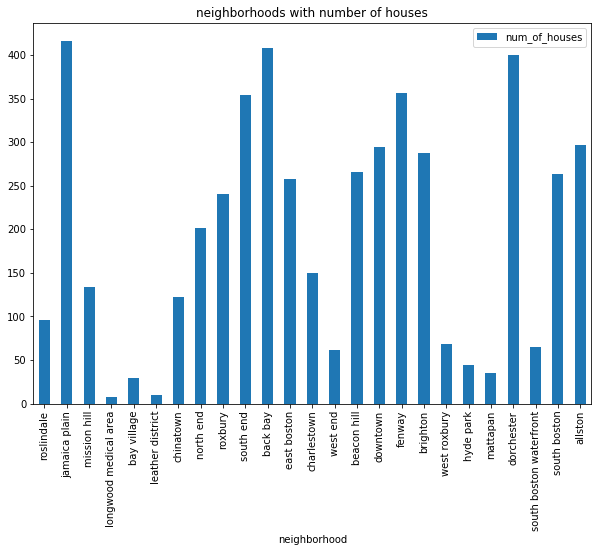

In [165]:
c.execute('''
            SELECT n.neighborhood, COUNT(f.listing_id) as number_of_houses
            FROM  fact_table f JOIN neighborhoods n ON f.neighborhood_id = n.id
            GROUP BY f.neighborhood_id
            
        ''')
dataframe = pd.DataFrame(data = c.fetchall(), columns = ['neighborhood', 'num_of_houses'])
dataframe.plot.bar(x='neighborhood', title='neighborhoods with number of houses', figsize=(10,7))

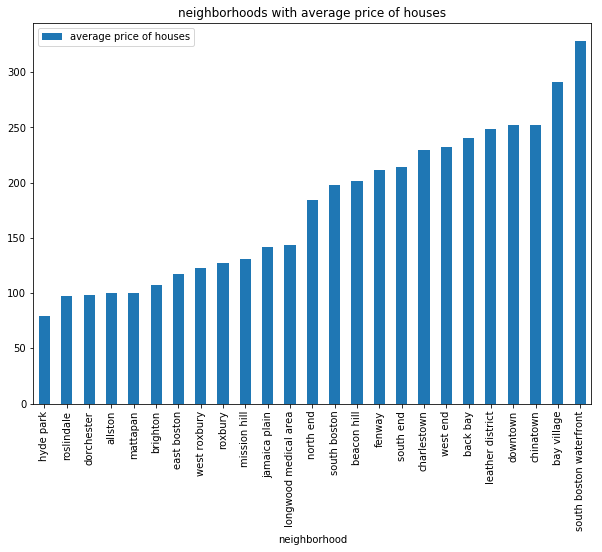

In [166]:
c.execute('''
            SELECT n.neighborhood, AVG(price) as average_price
            FROM fact_table f JOIN listings l ON f.listing_id = l.id
            JOIN neighborhoods n ON f.neighborhood_id = n.id
            GROUP BY f.neighborhood_id
            ORDER BY average_price
        ''')
dataframe = pd.DataFrame(data = c.fetchall(), columns = ['neighborhood', 'average price of houses'])
dataframe.plot.bar(x='neighborhood', title='neighborhoods with average price of houses', figsize=(10,7))

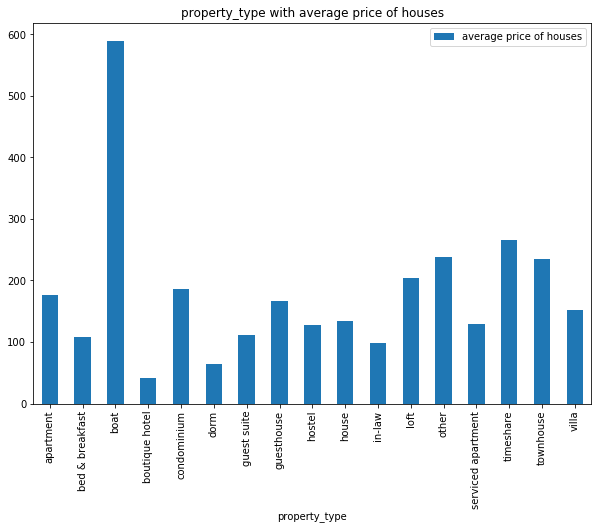

In [167]:
c.execute('''
SELECT property_type, AVG(price) as average_price
FROM listings
GROUP BY property_type
        ''')
dataframe = pd.DataFrame(data = c.fetchall(), columns = ['property_type', 'average price of houses'])
dataframe.plot.bar(x='property_type', title='property_type with average price of houses', figsize=(10,7))

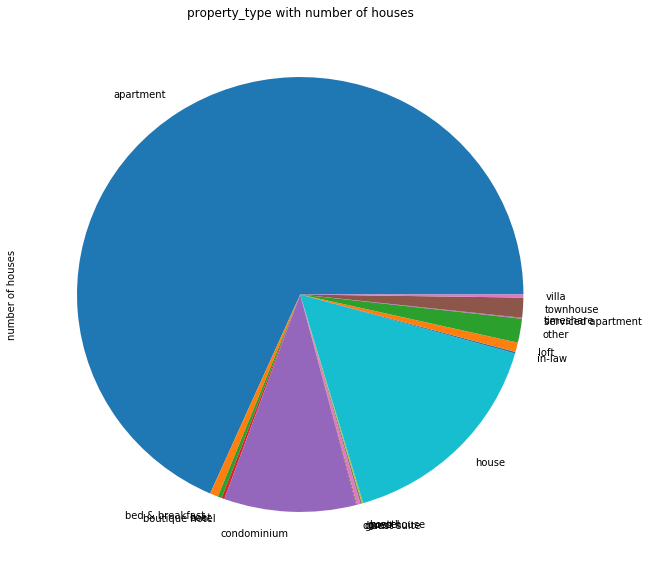

In [168]:
c.execute('''
SELECT property_type, COUNT(id) as num_of_houses
FROM listings
GROUP BY property_type
        ''')
dataframe = pd.DataFrame(data = c.fetchall(), columns = ['property_type', 'number of houses'])
dataframe['number of houses'].plot.pie(labels = dataframe['property_type'], title = "property_type with number of houses", 
                      figsize = (10, 10))


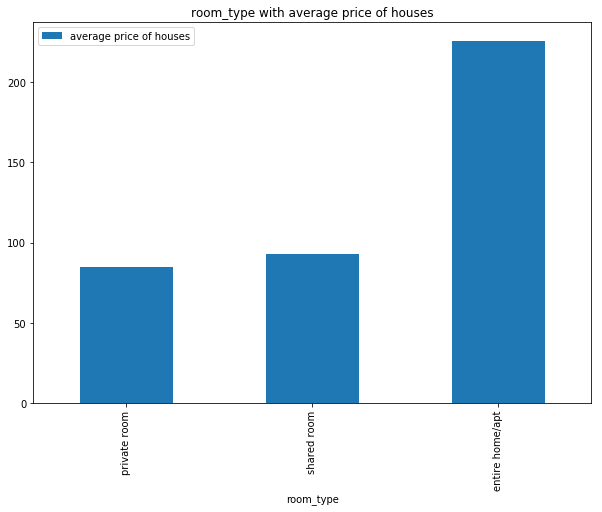

In [169]:
c.execute('''
SELECT room_type, AVG(price) as average_price
FROM listings
GROUP BY room_type
ORDER BY average_price
        ''')
dataframe = pd.DataFrame(data = c.fetchall(), columns = ['room_type', 'average price of houses'])
dataframe.plot.bar(x='room_type', title='room_type with average price of houses', figsize=(10,7))

In [170]:
%%sql
SELECT * 
FROM calendar
LIMIT 10

Done.


id,listing_id,mean_price_Jan,mean_price_Feb,mean_price_Mar,mean_price_Apr,mean_price_May,mean_price_Jun,mean_price_Jul,mean_price_Aug,mean_price_Sept,mean_price_Oct,mean_price_Nov,mean_price_Dec
1,20872145,45.0,45.07142857142857,47.74193548387097,6.1,0.0,0.0,0.0,0.0,0.0,17.451612903225808,42.0,45.0
2,13937181,40.645161290322584,41.785714285714285,42.096774193548384,4.5,0.0,0.0,0.0,0.0,0.0,14.516129032258064,31.5,42.096774193548384
3,3575220,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,8.064516129032258,0.0,12.903225806451612
4,17419858,6.967741935483871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.774193548387096,72.0,72.0
5,18202496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,16987125,47.0,47.0,49.0,6.966666666666667,0.0,0.0,0.0,0.0,0.0,24.258064516129032,47.0,47.0
7,1668313,53.0,53.57142857142857,54.935483870967744,55.53333333333333,56.0,56.0,56.0,56.0,56.0,54.70967741935484,57.2,53.0
8,13768853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,19248168,0.0,0.0,0.0,78.66666666666667,92.0,92.0,92.0,92.0,92.0,14.838709677419354,0.0,0.0
10,849408,253.19354838709677,250.42857142857142,251.90322580645162,156.7,192.7741935483871,18.6,0.0,0.0,0.0,7.709677419354839,0.0,229.4516129032258
